# CLAY v0 - Visualizing the embedding space

In [1]:
import sys

sys.path.append("../")

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from einops import rearrange

from src.datamodule import ClayDataModule, ClayDataset
from src.model_clay import CLAYModule

/home/mjonir/mambaforge/envs/claymodel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_DIR = "../data/02"  # data directory for all chips
CKPT_PATH = "../checkpoints/v0/mae_epoch-24_val-loss-0.46.ckpt"  # path of best model checkpoint for Clay v0

## Load Model & DataModule

In [4]:
# Load the model & set in eval mode
model = CLAYModule.load_from_checkpoint(
    CKPT_PATH, mask_ratio=0.0, shuffle=False
)  # No masking or shuffling of patches
model.eval();

In [5]:
data_dir = Path(DATA_DIR)

# Load the Clay DataModule
ds = ClayDataset(chips_path=list(data_dir.glob("**/*.tif")))
dm = ClayDataModule(data_dir=str(data_dir), batch_size=8)
dm.setup(stage="fit")

# Load the train DataLoader
trn_dl = iter(dm.train_dataloader())

Total number of chips: 414


In [6]:
# Load the first batch of chips
batch = next(trn_dl)
batch.keys()

dict_keys(['pixels', 'bbox', 'epsg', 'date', 'latlon', 'timestep', 'source_url'])

In [7]:
batch["pixels"].shape, batch["latlon"].shape, batch["timestep"].shape

(torch.Size([8, 13, 512, 512]), torch.Size([8, 2]), torch.Size([8, 3]))

In [51]:
def normalize(tensor):
    # Normalize tensor to [0, 1]
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())


def show(sample):
    # Rearrange and denormalize the sample
    sample = torch.einsum("chw -> hwc", sample)
    denorm_sample = sample * torch.as_tensor(dm.STD) + torch.as_tensor(dm.MEAN)

    # Extract and normalize RGB, VV, VH, and DEM channels
    rgb = normalize(denorm_sample[..., [2, 1, 0]])
    vv = normalize(denorm_sample[..., [10]])
    vh = normalize(denorm_sample[..., [11]])
    dem = denorm_sample[..., [12]]

    # Create SAR composite image
    sar = torch.cat((vv, vh, 0.5 * (vv + vh)), dim=-1)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(rgb * 2)
    axs[0].set_title("RGB")
    axs[1].imshow(sar * 2)
    axs[1].set_title("SAR")
    axs[2].imshow(dem, cmap="gray")
    axs[2].set_title("DEM")
    for ax in axs:
        ax.axis("off")

    plt.show()

In [9]:
# Extract chips from the batch
s0, s1, s2, s3, s4, s5, s6, s7 = batch["pixels"]

Each batch has chips of shape `13 x 512 x 512`, normalized `lat` & `lon` coords & normalized timestep information as `year`, `month` & `day`.

## Pass data through the CLAY model

In [11]:
# Pass the pixels through the encoder & decoder of CLAY
with torch.no_grad():
    # Move data from to the device of model
    batch["pixels"] = batch["pixels"].to(model.device)
    batch["timestep"] = batch["timestep"].to(model.device)
    batch["latlon"] = batch["latlon"].to(model.device)

    # Pass pixels, latlon, timestep through the encoder to create encoded patches
    (
        unmasked_patches,
        unmasked_indices,
        masked_indices,
        masked_matrix,
    ) = model.model.encoder(batch)

In [12]:
unmasked_patches.shape

torch.Size([8, 1538, 768])

In [13]:
patches = unmasked_patches[
    :, :-2, :
]  # Remove the last 2 embeddings, as they represent latlon & time information
patches.shape

torch.Size([8, 1536, 768])

In [14]:
# Rearrange the patches from latent style to image size of shape batch x group x height x width x channels
patches = rearrange(patches, "b (g l) d  -> b g l d", g=6)
patches = rearrange(patches, "b g (h w) d -> b g h w d", h=16, w=16)

CLAY groups Sentinel-2, Sentinel-1 & DEM data into groups of size 6 based on their sensor frequency & type.

- Group 0 - RGB - Bands 2, 1, 0 - Sentinel-2 - B04, B03, B02
- Group 1 - RedEdge - Bands 3, 4, 5, 7 - Sentinel-2 - B05, B06, B07, B8A
- Group 2 - NIR - Band 6 - Sentinel-2 - B08
- Group 3 - SWIR - Bands 8, 9 - Sentinel-2 - B11, B12
- Group 4 - SAR - Bands 10, 11 - Sentinel-1 - VV, VH
- Group 5 - DEM - Band 12 - DEM - DEM

In [15]:
# Get the patches from CUDA to CPU and convert to numpy
patches = patches.detach().cpu().numpy()
patches.shape

(8, 6, 16, 16, 768)

### RGB embedding space

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


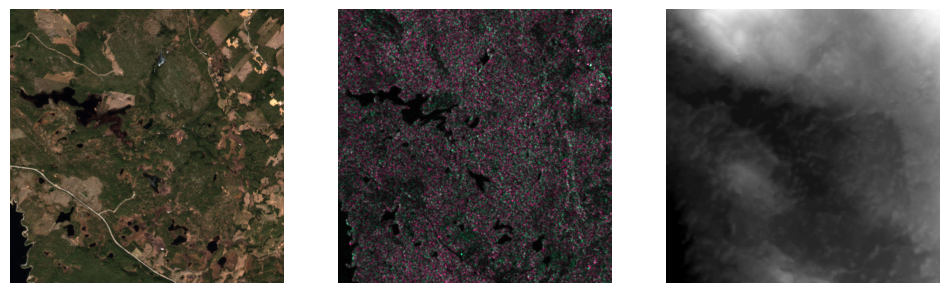

In [52]:
# Pick a random sample from the batch
order = 6
show(s6)

In [53]:
def show_in_grid(order, group):
    # Plot the embeddings in a grid, pass order and group to pick from a sample
    fig, axs = plt.subplots(5, 20, figsize=(15, 5))
    for idx, ax in enumerate(axs.flatten()):
        ax.imshow(patches[order][group][..., idx * 5])  # Pick every 5th embedding
        ax.set_axis_off()
    plt.tight_layout()

### RGB embedding space

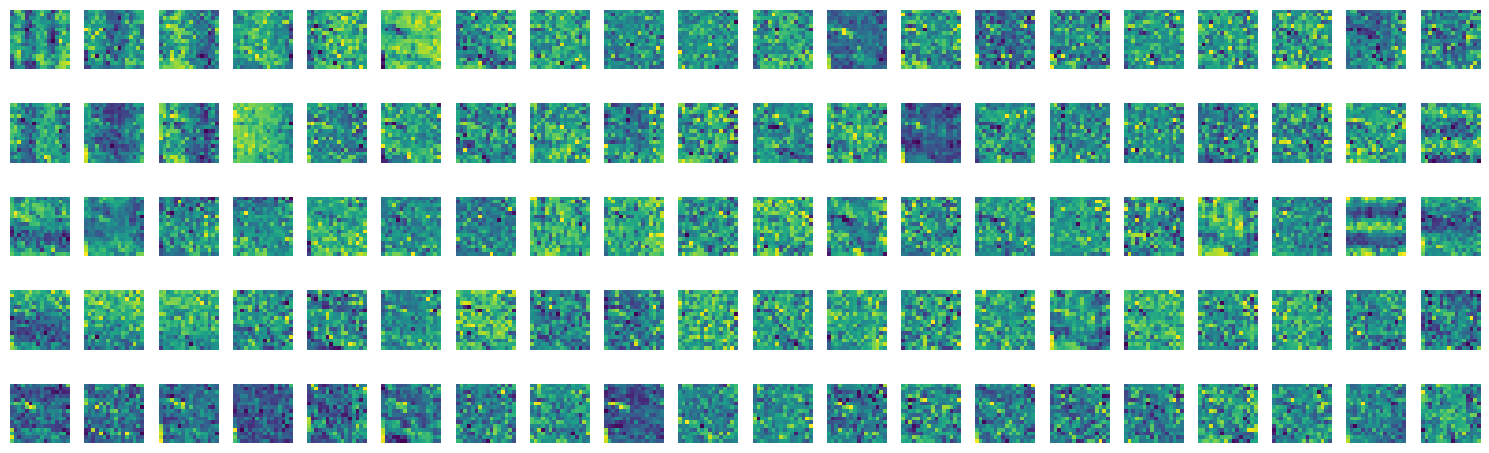

In [54]:
show_in_grid(order=6, group=0)

### SAR embedding space

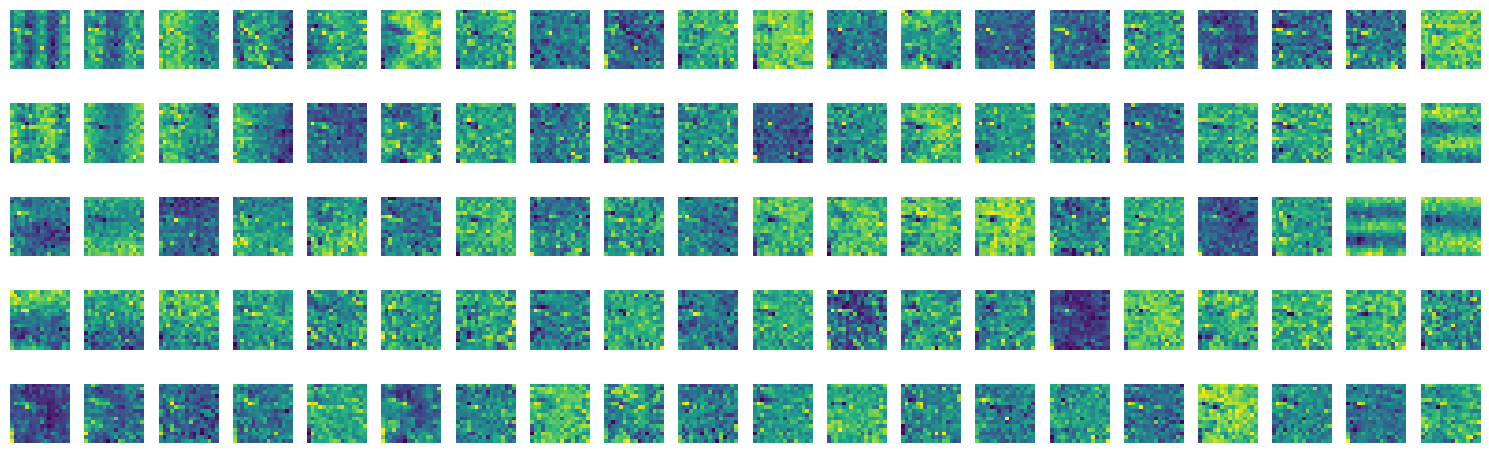

In [55]:
show_in_grid(order=6, group=4)

### DEM embedding space

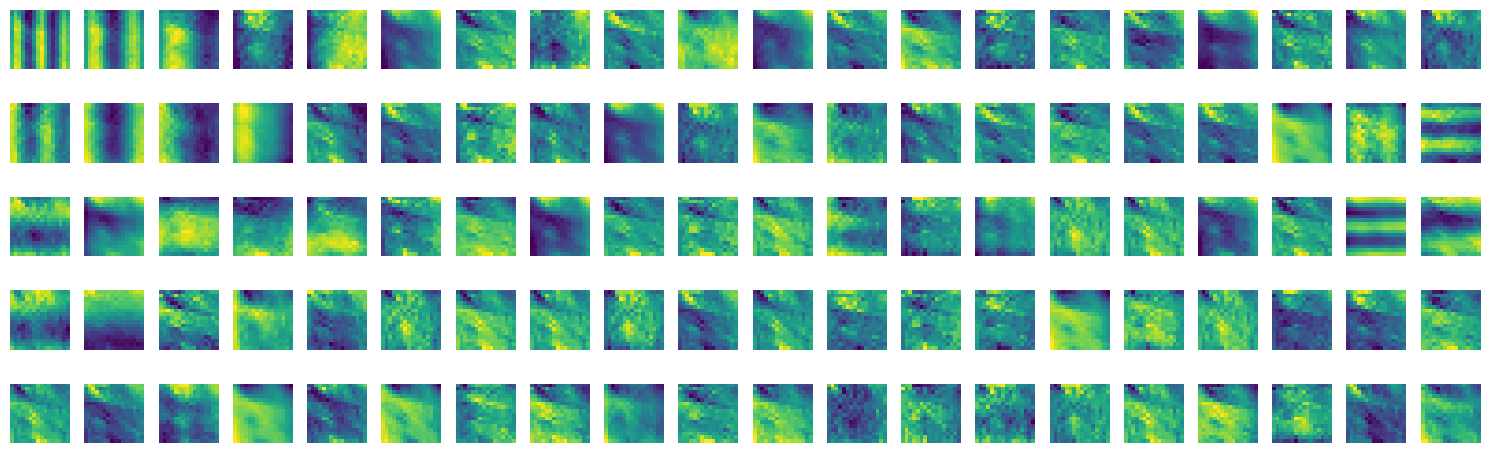

In [46]:
show_in_grid(order=6, group=5)